In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install -q transformers evaluate decord accelerate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.6/13.6 MB 32.7 MB/s eta 0:00:00


In [3]:
!unzip -q "/content/drive/MyDrive/action-video.zip" -d "/content/"

In [6]:
import torch
import cv2
import numpy as np
import copy
import os
from pathlib import Path
from tqdm.auto import tqdm
from PIL import Image
from torch.utils.data import Dataset, DataLoader, random_split
from transformers import (
    VideoMAEImageProcessor,
    VideoMAEForVideoClassification,
    TrainingArguments,
    Trainer
)
import evaluate

MODEL_CKPT = "MCG-NJU/videomae-base-finetuned-kinetics"
BATCH_SIZE = 4
EPOCHS = 8
NUM_FRAMES = 16
LEARNING_RATE = 5e-5
SEED = 42

TRAIN_DIR = Path('/content/action-video/data/data_train')
TEST_DIR = Path('/content/action-video/data/test')

In [14]:
class MotionAwareDataset(Dataset):
    def __init__(self, root_dir, image_processor, num_frames=16, is_train=True):
        self.root = root_dir
        self.image_processor = image_processor
        self.num_frames = num_frames
        self.is_train = is_train

        self.classes = sorted([d.name for d in self.root.iterdir() if d.is_dir()])
        self.class2id = {c: i for i, c in enumerate(self.classes)}
        self.id2class = {i: c for c, i in self.class2id.items()}

        self.samples = []
        print(f"🔍 Đang quét dữ liệu ({'TRAIN' if is_train else 'VAL/TEST'})...")
        for cls in self.classes:
            cls_path = self.root / cls
            for vid_folder in sorted([d for d in cls_path.iterdir() if d.is_dir()]):
                frames = sorted([str(p) for p in vid_folder.glob('*.jpg')])
                if len(frames) > 0:
                    self.samples.append((frames, self.class2id[cls]))
        print(f"   -> Tìm thấy {len(self.samples)} video.")

    def __len__(self):
        return len(self.samples)

    def _get_motion_score(self, img_path1, img_path2):
        """Tính độ sai lệch giữa 2 ảnh liên tiếp (Frame Difference)"""
        try:
            # Đọc ảnh xám và resize nhỏ (64x64) để tính nhanh
            im1 = cv2.imread(img_path1, cv2.IMREAD_GRAYSCALE)
            im2 = cv2.imread(img_path2, cv2.IMREAD_GRAYSCALE)
            if im1 is None or im2 is None: return 0

            im1 = cv2.resize(im1, (64, 64))
            im2 = cv2.resize(im2, (64, 64))

            # Tính tổng chênh lệch pixel (L1 distance)
            return np.sum(cv2.absdiff(im1, im2))
        except:
            return 0

    def __getitem__(self, idx):
        frame_paths, label = self.samples[idx]
        total_frames = len(frame_paths)

        # Thuật toán Sampling

        # 1. Lấy mẫu ứng viên (Candidates) - Lấy gấp đôi số lượng cần thiết
        candidate_count = min(total_frames, self.num_frames * 2)

        if total_frames <= self.num_frames:
            # Video ngắn quá thì lấy hết
            indices = np.arange(total_frames)
        else:
            # Chia đều video
            tick = total_frames / float(candidate_count)
            indices = np.array([int(tick / 2.0 + tick * x) for x in range(candidate_count)])

            # Chỉ Jitter (rung lắc vị trí) khi đang Train
            if self.is_train:
                noise = np.random.randint(-1, 2, size=len(indices))
                indices = indices + noise
                indices = np.clip(indices, 0, total_frames - 1)

        # 2. Tính điểm Motion và Lọc (Filter)
        # Nếu số lượng frame > num_frames, ta mới cần lọc lấy cái xịn nhất
        if len(indices) > self.num_frames:
            scores = []
            for i in indices:
                # So sánh với frame kế tiếp
                next_i = min(i + 1, total_frames - 1)
                # Nếu i là frame cuối cùng, so với frame trước nó
                if i == total_frames - 1: next_i = i - 1

                score = self._get_motion_score(frame_paths[i], frame_paths[next_i])
                scores.append(score)

            # Chọn Top K frame có điểm chuyển động cao nhất
            top_indices_local = np.argsort(scores)[-self.num_frames:]
            final_indices = indices[top_indices_local]

            # Sắp xếp lại theo thời gian
            final_indices = np.sort(final_indices)
        else:
            final_indices = indices

            # Padding nếu thiếu (Duplicate frame cuối)
            if len(final_indices) < self.num_frames:
                pad = [final_indices[-1]] * (self.num_frames - len(final_indices))
                final_indices = np.concatenate([final_indices, pad])


        video = []
        for i in final_indices:
            try:
                img_path = frame_paths[int(i)]
                img = Image.open(img_path).convert("RGB")
                video.append(np.array(img))
            except:
                # Fallback ảnh đen nếu lỗi file
                video.append(np.zeros((224, 224, 3), dtype=np.uint8))

        # Đưa vào Processor của HuggingFace
        inputs = self.image_processor(list(video), return_tensors="pt")

        return {
            "pixel_values": inputs["pixel_values"].squeeze(), # [16, 3, 224, 224]
            "labels": torch.tensor(label)
        }

In [15]:
# 1. Image Processor
image_processor = VideoMAEImageProcessor.from_pretrained(MODEL_CKPT)

# 2. Dataset
full_dataset = MotionAwareDataset(TRAIN_DIR, image_processor, num_frames=NUM_FRAMES, is_train=True)

# 3. Split Train/Val (80/20)
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_ds, val_ds = random_split(full_dataset, [train_size, val_size],
                                generator=torch.Generator())

val_ds.dataset = copy.deepcopy(full_dataset)
val_ds.dataset.is_train = False

print(f"\nThống kê: Train={len(train_ds)} | Val={len(val_ds)} | Classes={len(full_dataset.classes)}")

# 4. Load Model
model = VideoMAEForVideoClassification.from_pretrained(
    MODEL_CKPT,
    label2id=full_dataset.class2id,
    id2label=full_dataset.id2class,
    ignore_mismatched_sizes=True,
    num_frames=NUM_FRAMES
)

🔍 Đang quét dữ liệu (TRAIN)...
   -> Tìm thấy 6254 video.

Thống kê: Train=5003 | Val=1251 | Classes=51


config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of VideoMAEForVideoClassification were not initialized from the model checkpoint at MCG-NJU/videomae-base-finetuned-kinetics and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([400]) in the checkpoint and torch.Size([51]) in the model instantiated
- classifier.weight: found shape torch.Size([400, 768]) in the checkpoint and torch.Size([51, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [16]:
# Metric tính độ chính xác
metric = evaluate.load("accuracy")
def compute_metrics(eval_pred):
    predictions = np.argmax(eval_pred.predictions, axis=1)
    return metric.compute(predictions=predictions, references=eval_pred.label_ids)

# Cấu hình Trainer
args = TrainingArguments(
    output_dir="videomae-hmdb51-motion-aware",
    remove_unused_columns=False,
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=LEARNING_RATE,
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    num_train_epochs=EPOCHS,
    warmup_ratio=0.1,
    logging_steps=20,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    save_total_limit=2,
    fp16=True,
    gradient_accumulation_steps=4,
    dataloader_num_workers=2,
    report_to="none"
)

trainer = Trainer(
    model=model,
    args=args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    tokenizer=image_processor,
    compute_metrics=compute_metrics,
)

print("Bắt đầu Fine-tuning với chiến thuật Motion-Aware...")
trainer.train()

# Lưu model xịn nhất
best_model_path = "/content/drive/MyDrive/videomae_best_model_motion_aware"
trainer.save_model(best_model_path)
print(f"Đã lưu model tốt nhất tại: {best_model_path}")

/tmp/ipython-input-2550166718.py:28: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Bắt đầu Fine-tuning với chiến thuật Motion-Aware...


Epoch,Training Loss,Validation Loss,Accuracy
1,1.207200,1.085489,0.779376
2,0.518900,0.599631,0.854516
3,0.157200,0.491627,0.868106
4,0.061000,0.434798,0.882494
5,0.021200,0.427802,0.892086
6,0.020400,0.415201,0.899281
7,0.003000,0.407656,0.903277
8,0.002800,0.409496,0.905675


Đã lưu model tốt nhất tại: /content/drive/MyDrive/videomae_best_model_motion_aware


In [17]:
# Load lại model đã lưu
trained_model = VideoMAEForVideoClassification.from_pretrained(best_model_path).to("cuda")
trained_model.eval()

# Lấy danh sách folder test
test_folders = sorted([d for d in TEST_DIR.iterdir() if d.is_dir()], key=lambda x: int(x.name))
predictions = []

print("Running Inference on Test Set...")

with torch.no_grad():
    for vid_dir in tqdm(test_folders):
        vid_id = int(vid_dir.name)
        frames = sorted([str(p) for p in vid_dir.glob('*.jpg')])

        if len(frames) == 0: continue

        # --- Logic Motion Aware Inference ---
        # 1. Lấy candidates
        candidate_count = min(len(frames), NUM_FRAMES * 2)
        indices = np.linspace(0, len(frames)-1, candidate_count).astype(int)

        # 2. Tính Motion Score
        if len(indices) > NUM_FRAMES:
            scores = []
            for i in indices:
                next_i = min(i + 1, len(frames) - 1)
                # Tính frame difference
                try:
                    im1 = cv2.resize(cv2.imread(frames[i], 0), (64,64))
                    im2 = cv2.resize(cv2.imread(frames[next_i], 0), (64,64))
                    score = np.sum(cv2.absdiff(im1, im2))
                except: score = 0
                scores.append(score)

            # 3. Lấy Top K
            top_indices = np.argsort(scores)[-NUM_FRAMES:]
            final_indices = np.sort(indices[top_indices])
        else:
            final_indices = indices

        # 4. Load ảnh
        video = []
        for i in final_indices:
            try:
                img = Image.open(frames[i]).convert("RGB")
                video.append(np.array(img))
            except:
                video.append(np.zeros((224, 224, 3), dtype=np.uint8))

        while len(video) < NUM_FRAMES:
            video.append(video[-1])

        inputs = image_processor(list(video), return_tensors="pt")
        inputs = {k: v.to("cuda") for k, v in inputs.items()}

        logits = trained_model(**inputs).logits
        pred_label_idx = logits.argmax(-1).item()
        pred_class = full_dataset.id2class[pred_label_idx]

        predictions.append((vid_id, pred_class))

import pandas as pd
df = pd.DataFrame(predictions, columns=['id', 'class'])
df = df.sort_values(by='id')
df.to_csv('submission.csv', index=False)

print("Đã xong")

Running Inference on Test Set...


  0%|          | 0/510 [00:00<?, ?it/s]

Đã xong


⏳ Đang chạy dự đoán để vẽ ảnh...


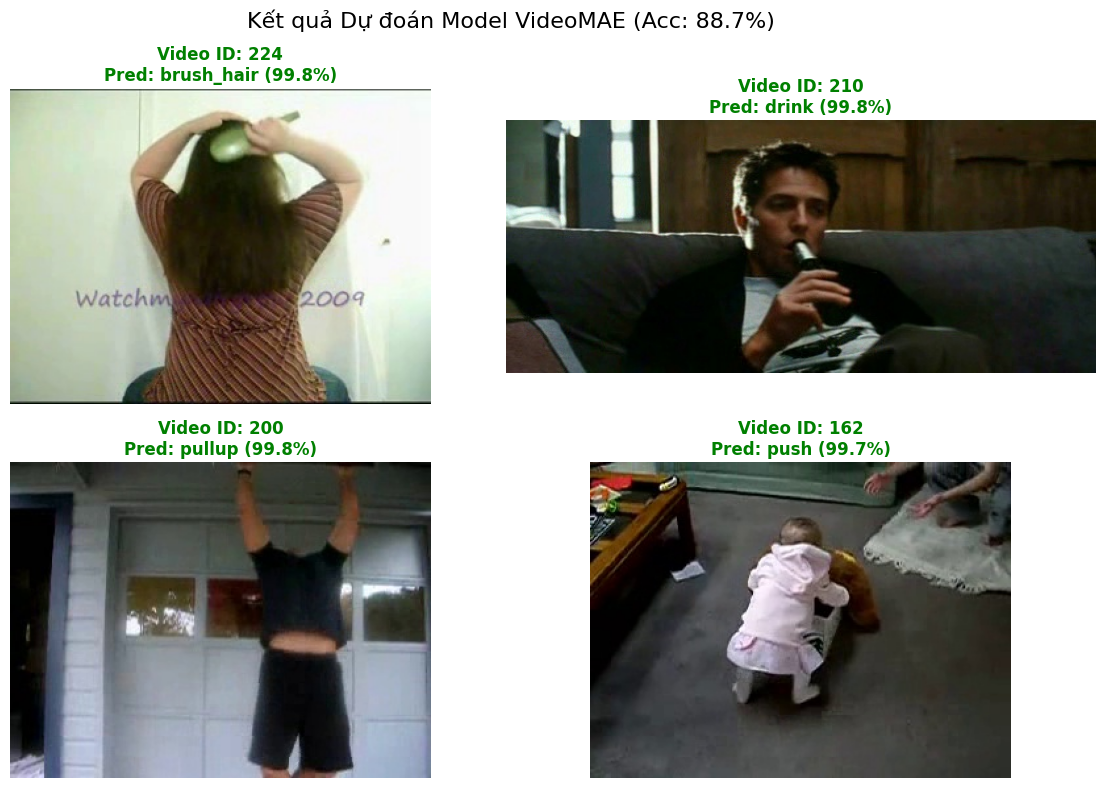

In [19]:
import matplotlib.pyplot as plt
import random
from PIL import Image

# Cấu hình
NUM_SAMPLES = 4
COLS = 2
ROWS = 2

trained_model.eval()

# Lấy ngẫu nhiên các mẫu từ tập Test
test_folders = sorted([d for d in TEST_DIR.iterdir() if d.is_dir()])
random_samples = random.sample(test_folders, NUM_SAMPLES)

fig, axes = plt.subplots(ROWS, COLS, figsize=(12, 8))
fig.suptitle(f'Kết quả Dự đoán Model VideoMAE (Acc: 88.7%)', fontsize=16)

print("⏳ Đang chạy dự đoán để vẽ ảnh...")

for idx, vid_dir in enumerate(random_samples):
    ax = axes[idx // COLS, idx % COLS]

    frames = sorted([str(p) for p in vid_dir.glob('*.jpg')])
    if len(frames) == 0: continue

    # Lấy frame giữa để hiển thị cho đẹp
    mid_frame_path = frames[len(frames)//2]
    display_img = Image.open(mid_frame_path)

    # 2. Xử lý Input cho Model
    indices = np.linspace(0, len(frames)-1, NUM_FRAMES).astype(int)
    video = []
    for i in indices:
        video.append(np.array(Image.open(frames[i]).convert("RGB")))

    inputs = image_processor(list(video), return_tensors="pt")
    inputs = {k: v.to("cuda") for k, v in inputs.items()}

    # 3. Predict
    with torch.no_grad():
        logits = trained_model(**inputs).logits
        pred_idx = logits.argmax(-1).item()
        confidence = torch.nn.functional.softmax(logits, dim=-1)[0][pred_idx].item()

    pred_label = full_dataset.id2class[pred_idx]

    # Lấy True Label

    # Vẽ ảnh
    ax.imshow(display_img)
    ax.axis('off')

    # Đổi màu tiêu đề: Xanh nếu tự tin cao, Đỏ nếu thấp
    color = 'green' if confidence > 0.7 else 'red'
    ax.set_title(f"Video ID: {vid_dir.name}\nPred: {pred_label} ({confidence:.1%})",
                 color=color, fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

🎥 Đang phân tích chuyển động của video: 398


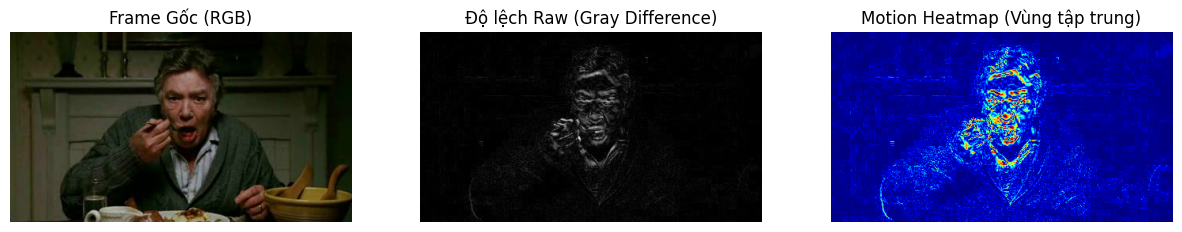

In [17]:
import cv2
import random
import matplotlib.pyplot as plt

def visualize_motion_mechanism(video_folder_path):
    """
    Vẽ minh họa cách thuật toán Motion-Aware nhìn thấy chuyển động
    """
    frames = sorted([str(p) for p in video_folder_path.glob('*.jpg')])
    if len(frames) < 2: return

    # Chọn 2 frame liên tiếp ở giữa video (thường có hành động mạnh nhất)
    mid = len(frames) // 2
    path1 = frames[mid]
    path2 = frames[mid + 1] # Frame kế tiếp

    # 1. Đọc ảnh gốc
    img1 = cv2.imread(path1)
    img2 = cv2.imread(path2)
    img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2RGB) # Để hiển thị plt

    # 2. Tính Frame Difference
    gray1 = cv2.cvtColor(img1, cv2.COLOR_RGB2GRAY)
    gray2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)

    # Tính sai biệt tuyệt đối
    diff = cv2.absdiff(gray1, gray2)

    # 3. Tạo Heatmap cho đẹp (để đưa vào báo cáo)
    # Tăng độ tương phản để nhìn rõ đốm chuyển động
    _, thresh = cv2.threshold(diff, 20, 255, cv2.THRESH_BINARY)

    # Tô màu (Heatmap) - Chỗ nào động thì màu đỏ/vàng
    heatmap = cv2.applyColorMap(diff * 5, cv2.COLORMAP_JET)
    heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB)

    # Vẽ
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    axes[0].imshow(img1)
    axes[0].set_title("Frame Gốc (RGB)")
    axes[0].axis('off')

    axes[1].imshow(diff, cmap='gray')
    axes[1].set_title("Độ lệch Raw (Gray Difference)")
    axes[1].axis('off')

    axes[2].imshow(heatmap)
    axes[2].set_title("Motion Heatmap (Vùng tập trung)")
    axes[2].axis('off')

    plt.show()

# --- CHẠY THỬ ---
# Lấy ngẫu nhiên 1 video từ tập Test để minh họa
test_folders = sorted([d for d in TEST_DIR.iterdir() if d.is_dir()])
if len(test_folders) > 0:
    sample_vid = random.choice(test_folders)
    print(f"🎥 Đang phân tích chuyển động của video: {sample_vid.name}")
    visualize_motion_mechanism(sample_vid)
else:
    print("Không tìm thấy video test nào.")